In [1]:
!pip install transformers datasets torch


  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [21]:
from datasets import load_dataset
import torch
from transformers import BertTokenizerFast, BertForQuestionAnswering, Trainer, TrainingArguments
import re

In [3]:
from datasets import Dataset

In [4]:
# Load the Quora Question Answer dataset
dataset = load_dataset('toughdata/quora-question-answer-dataset')


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/56402 [00:00<?, ? examples/s]

In [28]:
import logging
from transformers import logging as transformers_logging

# Set the logging level to ERROR to suppress warnings
logging.basicConfig(level=logging.ERROR)
transformers_logging.set_verbosity_error()


In [29]:
from transformers import BertTokenizer

# Initialize tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')

def preprocess_function(examples):
    # Ensure `examples` are lists of strings
    questions = [str(q) for q in examples['question']]
    answers = [str(a) for a in examples['answer']]

    # Tokenize the questions and answers
    encodings = tokenizer(
        questions,
        answers,
        truncation=True,
        padding='max_length',
        max_length=512,
        return_tensors=None  # Ensure tensors are not returned here; process them manually
    )

    # Convert lists to tensors manually if needed
    encodings['input_ids'] = torch.tensor(encodings['input_ids'])
    encodings['attention_mask'] = torch.tensor(encodings['attention_mask'])
    encodings['token_type_ids'] = torch.tensor(encodings.get('token_type_ids', []))

    # Example start and end positions (adjust based on your use case)
    encodings['start_positions'] = [0] * len(answers)  # Replace with actual start positions if available
    encodings['end_positions'] = [len(a.split()) - 1 for a in answers]  # Replace with actual end positions if available

    return encodings


# Apply preprocessing



In [31]:
tokenized_datasets = dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/56402 [00:00<?, ? examples/s]

In [32]:
# Test preprocessing on a small subset
test_examples = {
    'question': dataset['train']['question'][:5],
    'answer': dataset['train']['answer'][:5]
}
preprocessed = preprocess_function(test_examples)
print(preprocessed)


{'input_ids': tensor([[ 101, 2339, 7188,  ...,    0,    0,    0],
        [ 101, 2054, 2003,  ...,    0,    0,    0],
        [ 101, 2054, 2299,  ...,    0,    0,    0],
        [ 101, 1045, 2572,  ...,    0,    0,    0],
        [ 101, 2515, 1996,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': [0, 0, 0, 0, 0], 'end_positions': [14, 285, 1, 116, 30]}


In [33]:
from datasets import Dataset
import torch

# Convert processed data to Dataset object
def create_dataset(tokenized_data):
    return Dataset.from_dict({
        'input_ids': tokenized_data['input_ids'],
        'attention_mask': tokenized_data['attention_mask'],
        'token_type_ids': tokenized_data['token_type_ids'],
        'start_positions': tokenized_data['start_positions'],
        'end_positions': tokenized_data['end_positions']
    })
split_dataset = tokenized_datasets['train'].train_test_split(test_size=0.1)
train_dataset = create_dataset(split_dataset['train'])
eval_dataset = create_dataset(split_dataset['test'])

In [34]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [35]:
# Load pre-trained BERT model
model = BertForQuestionAnswering.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad').to(device)

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

In [36]:
# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=0.1,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    save_steps=1000,
    save_total_limit=2,
    remove_unused_columns=False
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [37]:
# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
)

In [38]:
# Fine-tune the model
trainer.train()


{'loss': 4.3965, 'grad_norm': 9.509129524230957, 'learning_rate': 1.984251968503937e-05, 'epoch': 0.000787959971633441}
{'loss': 3.0615, 'grad_norm': 5.325267314910889, 'learning_rate': 1.9685039370078743e-05, 'epoch': 0.001575919943266882}
{'loss': 2.8236, 'grad_norm': 14.934146881103516, 'learning_rate': 1.952755905511811e-05, 'epoch': 0.002363879914900323}
{'loss': 2.5961, 'grad_norm': 31.385046005249023, 'learning_rate': 1.937007874015748e-05, 'epoch': 0.003151839886533764}
{'loss': 2.4803, 'grad_norm': 10.991646766662598, 'learning_rate': 1.9212598425196852e-05, 'epoch': 0.003939799858167205}
{'loss': 2.2502, 'grad_norm': 13.36994457244873, 'learning_rate': 1.905511811023622e-05, 'epoch': 0.004727759829800646}
{'loss': 2.2386, 'grad_norm': 10.253837585449219, 'learning_rate': 1.8897637795275593e-05, 'epoch': 0.005515719801434087}
{'loss': 2.2475, 'grad_norm': 21.84055519104004, 'learning_rate': 1.8740157480314962e-05, 'epoch': 0.006303679773067528}
{'loss': 2.1231, 'grad_norm': 10

TrainOutput(global_step=1270, training_loss=1.8037055856599582, metrics={'train_runtime': 2425.9596, 'train_samples_per_second': 2.092, 'train_steps_per_second': 0.524, 'train_loss': 1.8037055856599582, 'epoch': 0.10007091639744702})

In [39]:
# Evaluate the model
results = trainer.evaluate()
print(results)


{'eval_loss': 1.4695841073989868, 'eval_runtime': 602.8744, 'eval_samples_per_second': 9.357, 'eval_steps_per_second': 2.34, 'epoch': 0.10007091639744702}
{'eval_loss': 1.4695841073989868, 'eval_runtime': 602.8744, 'eval_samples_per_second': 9.357, 'eval_steps_per_second': 2.34, 'epoch': 0.10007091639744702}


In [40]:
# Save the model and tokenizer
model.save_pretrained('./fine_tuned_bert_model')
tokenizer.save_pretrained('./fine_tuned_bert_model')

('./fine_tuned_bert_model/tokenizer_config.json',
 './fine_tuned_bert_model/special_tokens_map.json',
 './fine_tuned_bert_model/vocab.txt',
 './fine_tuned_bert_model/added_tokens.json',
 './fine_tuned_bert_model/tokenizer.json')

In [41]:
# Load the fine-tuned model and tokenizer
model = BertForQuestionAnswering.from_pretrained('./fine_tuned_bert_model').to(device)
tokenizer = BertTokenizer.from_pretrained('./fine_tuned_bert_model')

In [42]:

def get_answer(question, context):
    inputs = tokenizer.encode_plus(question, context, return_tensors='pt').to(device)
    input_ids = inputs["input_ids"].tolist()[0]

    # Get the start and end scores for the answer
    outputs = model(**inputs)
    answer_start_scores = outputs.start_logits
    answer_end_scores = outputs.end_logits

    # Get the most likely start and end token positions
    answer_start = torch.argmax(answer_start_scores)
    answer_end = torch.argmax(answer_end_scores) + 1

    # Convert token ids to answer text
    answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(input_ids[answer_start:answer_end]))
    return answer












In [43]:
# Get a subset of the dataset
subset_size = 10
questions_subset = dataset['train']['question'][:subset_size]
contexts_subset = dataset['train']['answer'][:subset_size]

# Generate and print answers for the subset
for question, context in zip(questions_subset, contexts_subset):
    answer = get_answer(question, context)
    print("Question:", question)
    print("Answer:", answer)
    print("\n")

Question: Why whenever I get in the shower my girlfriend want to join?
Answer: [CLS] why whenever i get in the shower my girlfriend want to join ?


Question: What is a proxy, and how can I use one?
Answer: [CLS] what is a proxy , and how can i use one ? [SEP] a proxy server is a system or router that provides a gateway between users and the internet . therefore , it helps prevent cyber attackers from entering a private network . it is a server , referred to as an “ intermediary ” because it goes between end - users and the web pages they visit online . when a computer connects to the internet , it uses an ip address . this is similar to your home ’ s street address , telling incoming data where to go and marking outgoing data with a return address for other devices to authenticate . a proxy server is essentially a computer on the internet that has an ip address of its own . how a proxy works because a proxy server has its own ip address , it acts as a go - between for a computer and t

**Distribution Plot**

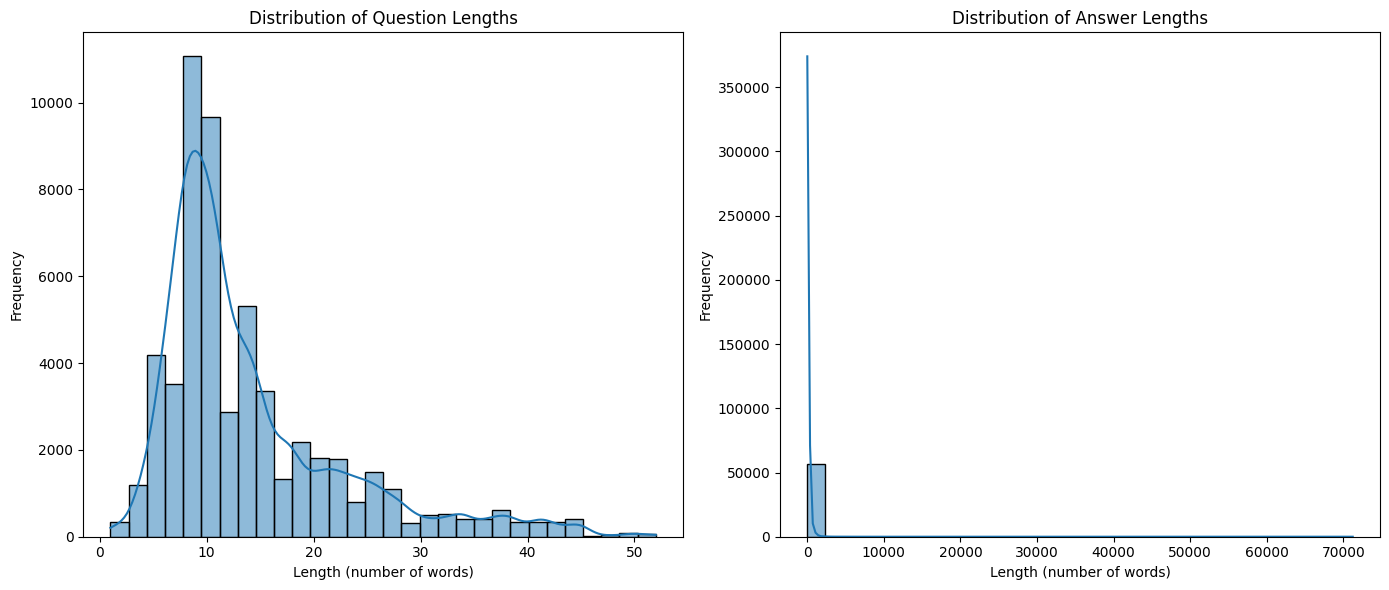

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Load dataset
from datasets import load_dataset
dataset = load_dataset('toughdata/quora-question-answer-dataset')

# Convert to pandas DataFrame for easier handling
df = pd.DataFrame(dataset['train'])

# Calculate lengths of questions and answers
df['question_length'] = df['question'].apply(lambda x: len(x.split()))
df['answer_length'] = df['answer'].apply(lambda x: len(x.split()))

# Plot distribution of question and answer lengths
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(df['question_length'], kde=True, bins=30)
plt.title('Distribution of Question Lengths')
plt.xlabel('Length (number of words)')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.histplot(df['answer_length'], kde=True, bins=30)
plt.title('Distribution of Answer Lengths')
plt.xlabel('Length (number of words)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


**Feature Importance**

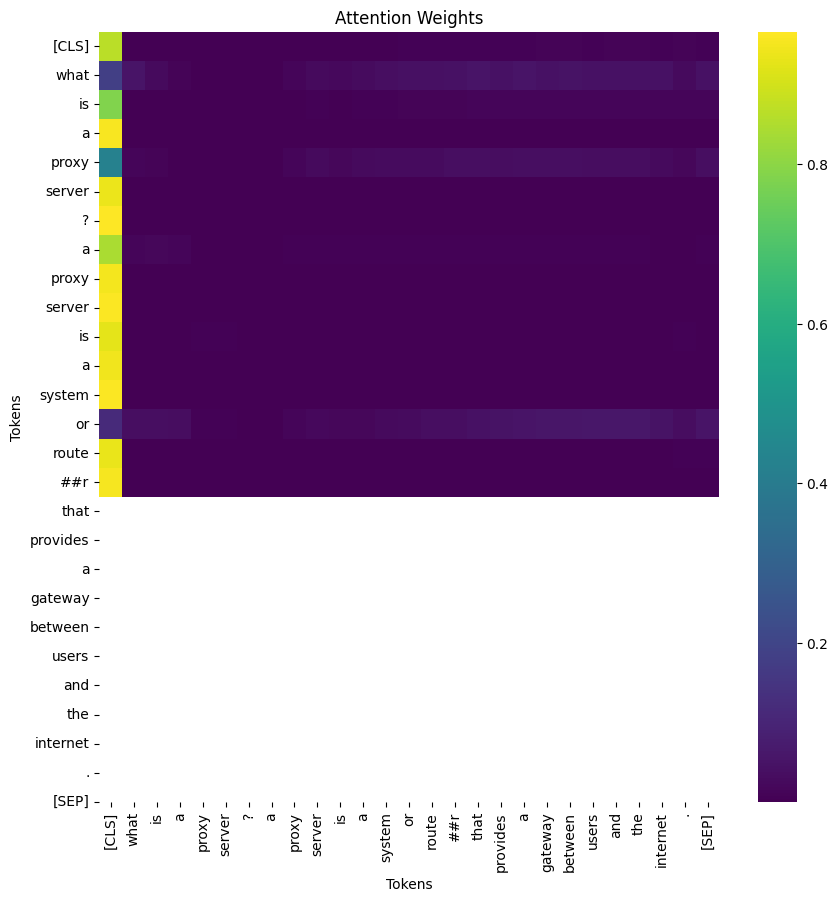

In [45]:
import torch
from transformers import BertTokenizer, BertModel
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load the fine-tuned model and tokenizer
model = BertModel.from_pretrained('./fine_tuned_bert_model', output_attentions=True)
tokenizer = BertTokenizer.from_pretrained('./fine_tuned_bert_model')

def get_attention_weights(input_text):
    inputs = tokenizer(input_text, return_tensors='pt', max_length=512, truncation=True)
    outputs = model(**inputs)

    # Extract attention weights from the outputs
    attentions = outputs.attentions
    return attentions

def visualize_attention(attentions, tokens):
    attention = attentions[-1][0]  # Use the last layer's attention
    attention = attention.mean(dim=1).squeeze().cpu().detach().numpy()  # Average attention heads

    # Plot heatmap of attention weights
    plt.figure(figsize=(10, 10))
    sns.heatmap(attention[:len(tokens), :len(tokens)], xticklabels=tokens, yticklabels=tokens, cmap='viridis')
    plt.title('Attention Weights')
    plt.xlabel('Tokens')
    plt.ylabel('Tokens')
    plt.show()

# Example usage
question = "What is a proxy server?"
context = "A proxy server is a system or router that provides a gateway between users and the internet."
input_text = f"{question} {context}"

# Get attention weights
attentions = get_attention_weights(input_text)

# Tokenize input
input_ids = tokenizer.encode(input_text, return_tensors='pt')[0]
tokens = tokenizer.convert_ids_to_tokens(input_ids)

# Visualize attention weights
visualize_attention(attentions, tokens)


**Model Performance**

In [46]:
# Extract logs
logs = trainer.state.log_history

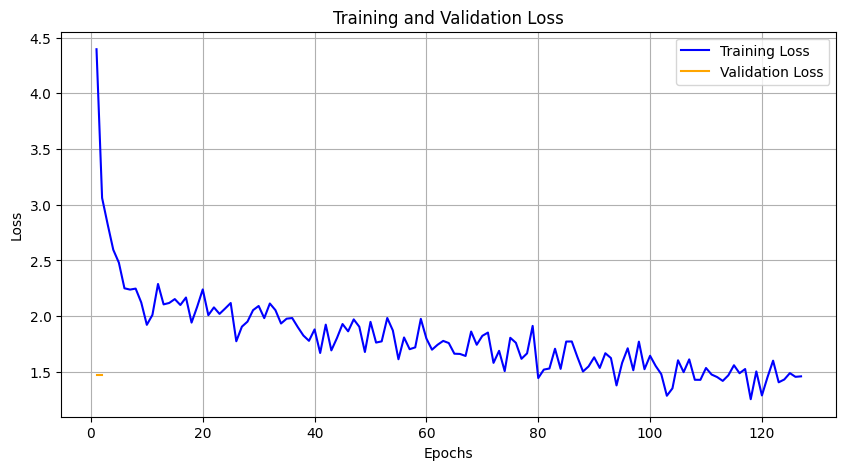

In [47]:
# Extract training and evaluation loss from logs
train_loss = [log['loss'] for log in logs if 'loss' in log]
eval_loss = [log['eval_loss'] for log in logs if 'eval_loss' in log]

# Create epoch range based on the length of the training loss
epochs_train = range(1, len(train_loss) + 1)
epochs_eval = range(1, len(eval_loss) + 1)

# Plot training and evaluation loss
plt.figure(figsize=(10, 5))

# Plot training loss
plt.plot(epochs_train, train_loss, label='Training Loss', color='blue')

# Plot evaluation loss only if it's available
if eval_loss:
    plt.plot(epochs_eval, eval_loss, label='Validation Loss', color='orange')

plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)  # Add grid for better readability
plt.show()
